<a href="https://colab.research.google.com/github/vmadalasa/END/blob/main/Session9/Model1/MV_NarrativeQAdataset_assignment1__S9_END.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The NarrativeQA Reading Comprehension Challenge

arvix paper - https://arxiv.org/pdf/1712.07040.pdf

The NarrativeQA Reading Comprehension Challenge

github link https://github.com/deepmind/narrativeqa

also used github project https://github.com/CpuKnows/NarrativeQA-Project for some doubts and inspiration

Reading comprehension (RC)—in contrast to
information retrieval—requires integrating information and reasoning about events, entities, and their relations across a full document.
Question answering is conventionally used to
assess RC ability, in both artificial agents and
children learning to read. However, existing
RC datasets and tasks are dominated by questions that can be solved by selecting answers
using superficial information (e.g., local context similarity or global term frequency); they
thus fail to test for the essential integrative aspect of RC. To encourage progress on deeper
comprehension of language, we present a new
dataset and set of tasks in which the reader
must answer questions about stories by reading
entire books or movie scripts. These tasks are
designed so that successfully answering their
questions requires understanding the underlying narrative rather than relying on shallow
pattern matching or salience. We show that although humans solve the tasks easily, standard
RC models struggle on the tasks presented here.
We provide an analysis of the dataset and the
challenges it presents.
RNN Seq2Seq Encoder Decoder solution with Learning Phrase Representation

# 2 - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation

In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). This model will achieve improved test perplexity whilst only using a single layer RNN in both the encoder and the decoder.

## Introduction

Let's remind ourselves of the general encoder-decoder model.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

We use our encoder (green) over the embedded source sequence (yellow) to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

In the previous model, we used an multi-layered LSTM as the encoder and decoder.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq4.png?raw=1)

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Why? Mainly because that's what they did in the paper (this paper also introduced GRUs) and also because we used LSTMs last time. To understand how GRUs (and LSTMs) differ from standard RNNS, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) link. Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same, and both are better than standard RNNs. 

## Preparing Data

All of the data preparation will be (almost) the same as last time, so we'll very briefly detail what each code block does. See the previous notebook for a recap.

We'll import PyTorch, TorchText, spaCy and a few standard modules.

### NarrativeQA dataset

#### Files
* documents.csv - contains document_id, set, kind, story_url, story_file_size, wiki_url, wiki_title, story_word_count, story_start, story_end. The word count is approximate after some basic cleanup and tokenization.

* third_party/wikipedia/summaries.csv - contains document_id, set, summary, summary_tokenized. The summaries are from Wikipedia.

* qaps.csv - contains document_id, set, question, answer1, answer2, question_tokenized, answer1_tokenized, answer2_tokenized.
download_stories.sh - script to download the stories.

* compare.sh - compare downloaded story's file size to the document size we had. (At the time of publication, all stories have <3.5% file difference (except one), likely due to punctuation encoding.)


In [1]:
!git clone https://github.com/deepmind/narrativeqa.git

Cloning into 'narrativeqa'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


### Necessary packages

In [2]:
# Packages
import pandas as pd
import numpy as np

#torch 
import torch
import torch.nn as nn

#optimization
import torch.optim as optim
from torchtext import data
from torchtext.data import Field, BucketIterator

#preprocessing
import spacy





import math
import time

In [3]:
import random
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load dataset

Load dataset and split into train, valid and test. We are picking question and answer1 columns to predict the seq2seq translations.

In [4]:
df_qaps = pd.read_csv('/content/narrativeqa/qaps.csv')
print(df_qaps.shape)
print("Columns of qaps: ",df_qaps.columns)
df_qaps[:10]

(46765, 8)
Columns of qaps:  Index(['document_id', 'set', 'question', 'answer1', 'answer2',
       'question_tokenized', 'answer1_tokenized', 'answer2_tokenized'],
      dtype='object')


,document_id,set,question,answer1,answer2,question_tokenized,answer1_tokenized,answer2_tokenized
0,0025577043f5090cd603c6aea60f26e236195594,test,Who is Mark Hunter?,He is a high school student in Phoenix.,A loner and outsider student with a radio stat...,Who is Mark Hunter ?,He is a high school student in Phoenix .,A loner and outsider student with a radio stat...
1,0025577043f5090cd603c6aea60f26e236195594,test,Where does this radio station take place?,It takes place in Mark's parents basement.,"Phoenix, Arizona",Where does this radio station take place ?,It takes place in Mark s parents basement .,"Phoenix , Arizona"
2,0025577043f5090cd603c6aea60f26e236195594,test,Why do more students tune into Mark's show?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...,Why do more students tune into Mark s show ?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...
3,0025577043f5090cd603c6aea60f26e236195594,test,Who commits suicide?,Malcolm.,Malcolm.,Who commits suicide ?,Malcolm .,Malcolm .
4,0025577043f5090cd603c6aea60f26e236195594,test,What does Paige jam into her microwave?,She jams her medals and accolades.,Her award medals,What does Paige jam into her microwave ?,She jams her medals and accolades .,Her award medals
5,0025577043f5090cd603c6aea60f26e236195594,test,What does Mark do with his radio station?,He dismantles it and attaches it to his mother...,Dismantle it.,What does Mark do with his radio station ?,He dismantles it and attaches it to his mother...,Dismantle it .
6,0025577043f5090cd603c6aea60f26e236195594,test,What does Mark tell the protesting students?,He tells them to make their own future.,That they should make their own future because...,What does Mark tell the protesting students ?,He tells them to make their own future .,That they should make their own future because...
7,0025577043f5090cd603c6aea60f26e236195594,test,Who gets arrested?,Mark and Nora.,Mark and Nora.,Who gets arrested ?,Mark and Nora .,Mark and Nora .
8,0025577043f5090cd603c6aea60f26e236195594,test,What does the radio show cause?,It causes trouble.,It causes much trouble in the community.,What does the radio show cause ?,It causes trouble .,It causes much trouble in the community .
9,0025577043f5090cd603c6aea60f26e236195594,test,Where does Mark Broadcast his station from?,Parent's Basement,At the basement of his home,Where does Mark Broadcast his station from ?,Parent s Basement,At the basement of his home


In [5]:
df_qaps['document_id'] == '0025577043f5090cd603c6aea60f26e236195594'

0         True
1         True
2         True
3         True
4         True
         ...  
46760    False
46761    False
46762    False
46763    False
46764    False
Name: document_id, Length: 46765, dtype: bool

### Download and load spacy models

This is going to be used for tokenization.

In [6]:
# Download and load spacy models for EN language. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [7]:

spacy_en = spacy.load('en')

#spacy_de = spacy.load('de')

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

Define the train and the test data set now

In [8]:
df_train_qaps = df_qaps[df_qaps['set'] == 'train'][['question', 'answer1']].reset_index(drop=True)
df_test_qaps = df_qaps[df_qaps['set'] == 'test'][['question', 'answer1']].reset_index(drop=True)
df_valid_qaps = df_qaps[df_qaps['set'] == 'valid'][['question', 'answer1']].reset_index(drop=True)
print("Train set:",df_train_qaps.shape, "Test set:",df_test_qaps.shape, "Valid set:",df_valid_qaps.shape)

Train set: (32747, 2) Test set: (10557, 2) Valid set: (3461, 2)


In [9]:
 print(vars(df_train_qaps[0:0]))

{'_is_copy': <weakref at 0x7fab2e283138; to 'DataFrame' at 0x7fab2f09cac8>, '_mgr': BlockManager
Items: Index(['question', 'answer1'], dtype='object')
Axis 1: RangeIndex(start=0, stop=0, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 0, dtype: object, '_item_cache': {}, '_attrs': {}}


In [10]:
df_qaps.groupby('set').agg('count')

,document_id,question,answer1,answer2,question_tokenized,answer1_tokenized,answer2_tokenized
set,,,,,,,
test,10557,10557,10557,10557,10557,10557,10557
train,32747,32747,32747,32747,32747,32747,32747
valid,3461,3461,3461,3461,3461,3461,3461


In [11]:
df_train_qaps[:10]

,question,answer1
0,Who is Miss Delmer?,the elderly spinster aunt of the Earl de Verse...
1,Who does Arabella Mason wed?,"Ben Keene, Delmar's valet"
2,How does Percival Keene get his name?,"Percival is Captain Delmar's first name, and K..."
3,Who is the bully that steals Percival's lunch?,"his teacher, Mr. O'Gallagher"
4,How does Percival get even with O'Gallagher af...,He sets them on fire with the teacher sitting ...
5,Who does Percival convince the Pirates to spare?,a rich Dutch merchant and his daughter Minnie
6,How does Percival save Captain Delmar's life?,"When the captain is ill, Percival takes his pl..."
7,What shocking news does Percival's mother admi...,Captain Delmar is Percival's father
8,What happens when Percival is captured by the ...,he is sentenced to execution
9,What news does Percival receive at the end of ...,He has been granted the right to use his fathe...


In [12]:
df_test_qaps[:10]

,question,answer1
0,Who is Mark Hunter?,He is a high school student in Phoenix.
1,Where does this radio station take place?,It takes place in Mark's parents basement.
2,Why do more students tune into Mark's show?,Mark talks about what goes on at school and in...
3,Who commits suicide?,Malcolm.
4,What does Paige jam into her microwave?,She jams her medals and accolades.
5,What does Mark do with his radio station?,He dismantles it and attaches it to his mother...
6,What does Mark tell the protesting students?,He tells them to make their own future.
7,Who gets arrested?,Mark and Nora.
8,What does the radio show cause?,It causes trouble.
9,Where does Mark Broadcast his station from?,Parent's Basement


In [13]:
#general junk commands


 #print(vars(df_train_qaps[0:0]))

### define the predictor and predicted

QUESTIONS - Field containing the questions predictors.
ANSWERS-  Field for prediction.

In [14]:
QUESTIONS = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
ANSWERS = Field(tokenize = tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [ ]:
#print(type(QUESTIONS))
#QUESTIONS.__dict__

In [15]:
params = [('question', QUESTIONS), ('answer1', ANSWERS)]

In [16]:
example_train = [data.Example.fromlist([df_train_qaps.question[i],df_train_qaps.answer1[i]], params) for i in range(df_train_qaps.shape[0])] 
example_valid = [data.Example.fromlist([df_valid_qaps.question[i],df_valid_qaps.answer1[i]], params) for i in range(df_valid_qaps.shape[0])] 
example_test = [data.Example.fromlist([df_test_qaps.question[i],df_test_qaps.answer1[i]], params) for i in range(df_test_qaps.shape[0])] 

In [17]:
# Creating dataset
train_data = data.Dataset(example_train, params)
valid_data = data.Dataset(example_valid, params)
test_data = data.Dataset(example_test, params)

In [18]:
print(vars(train_data.examples[10]))

{'question': ['what', 'is', 'the', 'name', 'of', 'the', 'de', 'versely', 'family', 'house', '?'], 'answer1': ['madeline', 'hall']}


Get counts of train and test size and reconcile with total
32747+3462+10557

In [19]:
32747+3462+10557
#46765 totl as per beginnign

46766

In [20]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 32747
Number of validation examples: 3461
Number of testing examples: 10557


### Build SRC and TRG
Then create our vocabulary, converting all tokens appearing less than twice into <unk> tokens.

In [21]:
QUESTIONS.build_vocab(train_data, min_freq = 2)
ANSWERS.build_vocab(train_data, min_freq = 2)

In [22]:
print("Size of Source vocab: ",len(QUESTIONS.vocab))
print("Size of Target vocab: ",len(ANSWERS.vocab))

Size of Source vocab:  10574
Size of Target vocab:  10695


In [23]:
vars(QUESTIONS)
vars(ANSWERS)

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True,
 'vocab': <torchtext.vocab.Vocab at 0x7fab29f3f978>}

In [24]:

print(QUESTIONS.vocab.__dict__.keys())
#QUESTIONS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


In [25]:
print(ANSWERS.vocab.__dict__.keys())
#ANSWERS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


### Finally, define the `device` and create our iterators.



In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

In [28]:
batch = next(iter(train_iterator))

### Building the Seq2Seq Model
<a name="model"></a>
Using single layered GRU network.


### Encoder

The encoder is similar to the previous one, with the multi-layer LSTM swapped for a single-layer GRU. We also don't pass the dropout as an argument to the GRU as that dropout is used between each layer of a multi-layered RNN. As we only have a single layer, PyTorch will display a warning if we try and use pass a dropout value to it.

Another thing to note about the GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})\\
h_t &= \text{RNN}(e(x_t), h_{t-1})
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). Again, for more info, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post. 

The rest of the encoder should be very familar from the last session, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

This is identical to the encoder of the general seq2seq model, with all the "magic" happening inside the GRU (green).

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq5.png?raw=1)

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        
        #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

#### Decoder
## Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$

Note how this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder. 

Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as $\hat{y}_{t+1}=f(s_t^L)$. Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

Thus, our decoder now looks something like this:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq6.png?raw=1)

Note, the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that says differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!

hypothetically the decoder hidden states,  st , no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of  yt  to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state.


Within the implementation, we will pass $d(y_t)$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `emb_dim + hid_dim` (as context vector will be of size `hid_dim`). The linear layer will take $d(y_t), s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dim + hid_dim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `emb_con` before feeding to the GRU, and we concatenate $d(y_t)$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

In [30]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim + 2 * hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb_dim]

        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, batch size, emb_dim + hid_dim]

        output, hidden = self.rnn(emb_con, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        # output = [batch size, emb dim + 2 * hid dim]

        prediction = self.fc_out(output)
        # prediction = [batch_size, output_dim]

        return prediction, hidden 

#### Seq2Seq model

Putting the encoder and decoder together, we get:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)


In [31]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        context = self.encoder(src)

        # context is also used as the initial hidden state of the decoder
        hidden = context

        # fist input to the decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training the Seq2Seq Model
The rest of this session is very similar to the previous one. 

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [32]:
INPUT_DIM = len(QUESTIONS.vocab)
OUTPUT_DIM = len(ANSWERS.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

#### Initialize model parameters
Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10574, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10695, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=10695, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,297,031 trainable parameters


#### Initialize optimizer and loss function.

In [35]:
optimizer = optim.Adam(model.parameters())

In [36]:
TRG_PAD_IDX = ANSWERS.vocab.stoi[ANSWERS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

#### TRAIN loop

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        question = batch.question
        answer = batch.answer1
        
        optimizer.zero_grad()
        
        output = model(question, answer)
        
        #answer = [answer len, batch size]
        #output = [answer len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        answer = answer[1:].view(-1)
        
        #answer = [(answer len - 1) * batch size]
        #output = [(answer len - 1) * batch size, output dim]
        
        loss = criterion(output, answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Eval loop

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            question = batch.question
            answer = batch.answer1
            print

            output = model(question, answer, 0) #turn off teacher forcing

            #answer = [answer len, batch size]
            #output = [answer len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            answer = answer[1:].view(-1)

            #answer = [(answer len - 1) * batch size]
            #output = [(answer len - 1) * batch size, output dim]

            loss = criterion(output, answer)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model train

In [40]:
train_loss_all = []
val_loss_all = []

In [41]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_loss_all.append(train_loss)
    val_loss_all.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 52s
	Train Loss: 6.065 | Train PPL: 430.386
	 Val. Loss: 5.328 |  Val. PPL: 205.970
Epoch: 02 | Time: 0m 53s
	Train Loss: 5.569 | Train PPL: 262.203
	 Val. Loss: 5.316 |  Val. PPL: 203.580
Epoch: 03 | Time: 0m 54s
	Train Loss: 5.437 | Train PPL: 229.856
	 Val. Loss: 5.306 |  Val. PPL: 201.479
Epoch: 04 | Time: 0m 54s
	Train Loss: 5.237 | Train PPL: 188.085
	 Val. Loss: 5.264 |  Val. PPL: 193.289
Epoch: 05 | Time: 0m 54s
	Train Loss: 5.094 | Train PPL: 163.091
	 Val. Loss: 5.194 |  Val. PPL: 180.177
Epoch: 06 | Time: 0m 54s
	Train Loss: 4.932 | Train PPL: 138.666
	 Val. Loss: 5.146 |  Val. PPL: 171.799
Epoch: 07 | Time: 0m 54s
	Train Loss: 4.757 | Train PPL: 116.420
	 Val. Loss: 5.168 |  Val. PPL: 175.583
Epoch: 08 | Time: 0m 54s
	Train Loss: 4.589 | Train PPL:  98.389
	 Val. Loss: 5.178 |  Val. PPL: 177.286
Epoch: 09 | Time: 0m 54s
	Train Loss: 4.388 | Train PPL:  80.456
	 Val. Loss: 5.249 |  Val. PPL: 190.469
Epoch: 10 | Time: 0m 54s
	Train Loss: 4.156 | Train PPL

In [42]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.192 | Test PPL: 179.907 |



Learnings-

1. The decoder takes the context vector (generated from encoder) along with embedded input token and previous hidden state to predict hidden state (s_t)
2. The context vector is fed to the linear layer along with hidden output to predict the next token.

3. Train, test and val split was done as per the set division provided in the dataset. Train, test, val splits do not share documents. Hence, their information is not leaked. Test loss observed = 5.2 (Perplexity score=183)

Train, val loss curve

In [43]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

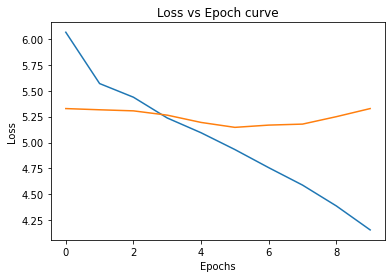

In [44]:
train_test_metrics_graph(train_loss_all, val_loss_all)